In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
from scipy.stats import linregress
from pprint import pprint

# Import the API key
from api_keys import alpha_vantage_api_key, bls_api_key

In [2]:
# Do NOT EXECUTE, AS API has rate-Limiting, we will use yfinance, EXECUTE THE NEXT CELL
# Constants
stock_symbol = 'QQQ'
# START_DATE = '2013-01-01'
# END_DATE = '2023-01-01'
URL = f'https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol={stock_symbol}&apikey={alpha_vantage_api_key}'


# Fetch stock data from alphavantage
response = requests.get(URL).json()

# Define an empty list to fetch the stock data
stock_data = []

for date, values in response['Time Series (Daily)'].items():
    stock_data.append({
        "Date": date,
        "Open": values['1. open'],
        "High": values['2. high'],
        "Low": values['3. low'],
        "Close": values['4. close'],
        "Volume": values['5. volume']
    })

# Conver List to dataFrame
stock_info_df = pd.DataFrame(stock_data)
stock_info_df.set_index("Date", inplace=True)

KeyError: 'Time Series (Daily)'

In [10]:
# Create a dataFrame for Nasdaq Monthly profit

import yfinance as yf
import pandas as pd
import calendar

stock_data = yf.download('QQQ', start='2014-01-01', end='2019-12-31', progress=False).reset_index()

# Date, Month Column creation by using Date
stock_data['Year'] = stock_data['Date'].dt.year
stock_data['Month_Number'] = stock_data['Date'].dt.month

# Open price for each Year, Month & Close price for each Year, Month
monthly_data = stock_data.groupby(['Year', 'Month_Number'])
first_open = monthly_data['Open'].first().reset_index()
last_close = monthly_data['Close'].last().reset_index()

# Monthly Profit 
monthly_profit = last_close['Close'] - first_open['Open']

# dataFrame creation
monthly_profit_df = pd.DataFrame({
                                    'Year': first_open['Year'],
                                    'Month_Number': first_open['Month_Number'],
                                    'Monthly_Profit': monthly_profit
                                })



# Generate month numbers (1-12)
month_numbers = list(range(1, 13))

# Use list comprehension to map month numbers to month names
month_names = [calendar.month_name[month] for month in month_numbers]

# Create the DataFrame
month_df = pd.DataFrame({
                            'Month_Number': month_numbers,
                            'Month': month_names
                        })

# Merge the DataFrames on 'Month' from monthly_profit_df and 'Month Number' from month_df
monthly_profit_merge_df = pd.merge(monthly_profit_df, month_df, left_on='Month_Number', right_on='Month_Number', how='left')

monthly_profit_final_df = monthly_profit_merge_df[["Year", "Month", "Monthly_Profit"]]
monthly_profit_final_df["Year"] = monthly_profit_final_df["Year"].astype('str')

monthly_profit_final_df


C:\Users\ZZ04DI616\AppData\Local\Temp\ipykernel_1976\3763593497.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monthly_profit_final_df["Year"] = monthly_profit_final_df["Year"].astype('str')


,Year,Month,Monthly_Profit
0,2014,January,-1.280006
1,2014,February,4.229996
2,2014,March,-1.820000
3,2014,April,-0.709999
4,2014,May,3.779999
...,...,...,...
67,2019,August,-3.959991
68,2019,September,2.589996
69,2019,October,7.580002
70,2019,November,7.170013


In [11]:
# Create a dataFrame for Monthly Unployment Rate

URL = 'https://api.bls.gov/publicAPI/v2/timeseries/data/'

api_key = bls_api_key
series_id = 'LNS14000000'  # Series ID for US unemployment rate

# Parameter setting
params = {
    'seriesid': [series_id],
    'startyear': '2014',  # Start Year
    'endyear': '2019',    # End Year
    'registrationKey': api_key
}

# Fetch unemployment data from BLS
response = requests.post(URL, json=params)
unemployment_data = response.json()

# Initialize an empty list to hold the unemployment data
unemployment_list = []

# Extract data from the response
series_data = unemployment_data["Results"]["series"][0]["data"]
for item in series_data:
    unemployment_list.append({
                                "Year": item["year"],
                                "Month": item["periodName"],
                                "Rate": item["value"]
                            })

# Convert the list to a DataFrame
unemployment_data_df = pd.DataFrame(unemployment_list).reset_index(drop=True)
unemployment_data_df["Rate"] = unemployment_data_df["Rate"].astype('float')

# Print the DataFrame
unemployment_data_df

,Year,Month,Rate
0,2019,December,3.6
1,2019,November,3.6
2,2019,October,3.6
3,2019,September,3.5
4,2019,August,3.6
...,...,...,...
67,2014,May,6.3
68,2014,April,6.2
69,2014,March,6.7
70,2014,February,6.7


In [12]:
# Merge two dataFrame (Nasdaq Monthly profit + Monthly Unployment Rate)

MonthlyProfit_Unemploy_df = pd.merge(monthly_profit_final_df, unemployment_data_df, on= ["Year","Month"], how="inner")

MonthlyProfit_Unemploy_df

,Year,Month,Monthly_Profit,Rate
0,2014,January,-1.280006,6.6
1,2014,February,4.229996,6.7
2,2014,March,-1.820000,6.7
3,2014,April,-0.709999,6.2
4,2014,May,3.779999,6.3
...,...,...,...,...
67,2019,August,-3.959991,3.6
68,2019,September,2.589996,3.5
69,2019,October,7.580002,3.6
70,2019,November,7.170013,3.6


<Axes: xlabel='Rate', ylabel='Monthly_Profit'>

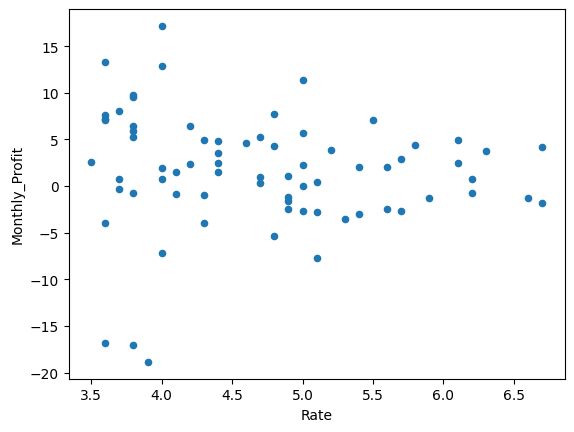

In [13]:
MonthlyProfit_Unemploy_df.plot(kind='scatter', x='Rate', y='Monthly_Profit')